In [1]:
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, NearMiss
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from scipy.stats import chi2_contingency
import warnings
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
train_path = os.path.join("..", "data", "input", "train_encoded.csv")
val_path = os.path.join("..", "data", "input", "val_encoded.csv")
test_path = os.path.join("..", "data", "input", "test_encoded.csv")
y_train_path = os.path.join("..", "data", "input", "y_train.csv")
y_path = os.path.join("..", "data", "input", "target.csv")
# this should be the one we use
# test_path = os.path.join("..", "data", "input", "y_bin.csv")

X_train = pd.read_csv(train_path, index_col=0)
X_val = pd.read_csv(val_path, index_col=0)
test = pd.read_csv(test_path, index_col=0)
y_train = pd.read_csv(y_train_path, index_col=0)
y = pd.read_csv(y_path, index_col=0)

## Feature Selection

### (former) continous variables

In [3]:
# correlation matrix for former metric features

metric_features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses',
    'age_mean',
    'outpatient_visits_in_previous_year_log',
    'emergency_visits_in_previous_year_log',
    'inpatient_visits_in_previous_year_log',
    'length_of_stay_in_hospital_log',
    'non_lab_procedures_log',
    'number_of_medications_log',
    'number_diagnoses_log',
    'age_mean_log',
    'outpatient_visits_in_previous_year_win_log',
    'emergency_visits_in_previous_year_win_log',
    'inpatient_visits_in_previous_year_win_log',
    'length_of_stay_in_hospital_win_log',
    'non_lab_procedures_win_log',
    'number_of_medications_win_log',
    'number_diagnoses_win_log',
    'age_mean_win_log'
 ]

X_train.loc[:, metric_features]

,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses,age_mean,...,number_diagnoses_log,age_mean_log,outpatient_visits_in_previous_year_win_log,emergency_visits_in_previous_year_win_log,inpatient_visits_in_previous_year_win_log,length_of_stay_in_hospital_win_log,non_lab_procedures_win_log,number_of_medications_win_log,number_diagnoses_win_log,age_mean_win_log
0,-1.000000,-1.0,-1.000000,-0.164557,-0.692308,0.059829,0.333333,-0.162162,0.066667,1.000000,...,-0.445252,1.000000,-1.000000,-1.0,-1.000000,-0.250351,0.924220,0.684633,1.000000,1.000000
1,-1.000000,-1.0,-1.000000,-0.645570,-0.230769,-0.025641,-1.000000,-0.837838,-0.333333,0.578947,...,-0.776945,0.672476,-1.000000,-1.0,-1.000000,0.281196,-1.000000,-0.537811,-0.342347,0.672476
2,-1.000000,-1.0,-1.000000,-0.417722,-0.846154,-0.521368,-0.666667,-0.837838,-0.466667,0.789474,...,-0.852588,0.838589,-1.000000,-1.0,-1.000000,-0.539649,0.673144,-0.537811,-0.608926,0.838589
3,-1.000000,-1.0,-0.714286,-0.822785,-0.846154,-0.418803,-1.000000,-0.891892,0.066667,0.578947,...,-0.445252,0.672476,-1.000000,-1.0,0.971985,-0.539649,-1.000000,-0.736580,1.000000,0.672476
4,-1.000000,-1.0,-1.000000,0.670886,-0.538462,-0.333333,-0.666667,-0.594595,-0.333333,0.578947,...,-0.776945,0.672476,-1.000000,-1.0,-1.000000,-0.035577,0.673144,0.052677,-0.342347,0.672476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101251,-1.000000,-1.0,-1.000000,0.316456,-0.538462,-0.504274,-0.333333,-0.567568,-0.066667,0.789474,...,-0.573834,0.838589,-1.000000,-1.0,-1.000000,-0.035577,0.797151,0.102491,0.453390,0.838589
101252,-1.000000,-1.0,-1.000000,-0.139241,-0.692308,-0.846154,-1.000000,-0.297297,0.066667,0.789474,...,-0.445252,0.838589,-1.000000,-1.0,-1.000000,-0.250351,-1.000000,0.516434,1.000000,0.838589
101253,-1.000000,-1.0,-0.904762,-0.696203,-0.538462,-0.076923,-1.000000,-0.729730,0.066667,0.578947,...,-0.445252,0.672476,-1.000000,-1.0,0.920030,-0.035577,-1.000000,-0.234509,1.000000,0.672476
101254,-1.000000,-1.0,-1.000000,-0.949367,0.230769,0.076923,0.333333,-0.378378,0.066667,0.789474,...,-0.445252,0.838589,-1.000000,-1.0,-1.000000,0.615236,0.924220,0.405119,1.000000,0.838589


In [4]:
y_train["readmitted_binary"] = y_train.replace({'Yes': 1, 'No': 0})
y_val = y.loc[X_val.index]
y_val["readmitted_binary"] = y_val.replace({'Yes': 1, 'No': 0})

y_train.shape[0] + y_val.shape[0]

115504

In [5]:
X_rand = X_train[metric_features].sample(frac=1, axis=1)
X_val_metric = X_val[metric_features].reindex(columns=X_rand.columns)

In [6]:
X_val_metric

,length_of_stay_in_hospital_win_log,number_diagnoses_win_log,average_pulse_bpm,non_lab_procedures,length_of_stay_in_hospital,number_of_medications_log,number_of_medications,age_mean_win_log,number_of_medications_win_log,inpatient_visits_in_previous_year,...,emergency_visits_in_previous_year_log,emergency_visits_in_previous_year_win_log,outpatient_visits_in_previous_year,inpatient_visits_in_previous_year_log,emergency_visits_in_previous_year,number_diagnoses,age_mean_log,non_lab_procedures_log,length_of_stay_in_hospital_log,outpatient_visits_in_previous_year_log
encounter_id,,,,,,,,,,,,,,,,,,,,,
401962,-1.000000,-0.342347,0.265823,0.333333,-1.000000,-0.132029,-0.648649,0.136365,-0.053668,-1.000000,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-0.333333,0.136365,0.924220,-1.000000,-1.000000
617565,0.406108,-0.608926,-0.645570,-0.333333,-0.076923,-0.097170,-0.621622,0.672476,0.000707,-1.000000,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-0.466667,0.672476,0.797151,0.406108,-1.000000
356044,-0.250351,-0.608926,-0.924051,-1.000000,-0.692308,-0.247615,-0.729730,0.672476,-0.234509,-0.904762,...,-1.000000,-1.00000,-1.000000,0.879697,-1.000000,-0.466667,0.672476,-1.000000,-0.250351,-1.000000
486082,-1.000000,-0.342347,-0.848101,-1.000000,-1.000000,-0.063809,-0.594595,0.500864,0.052677,-1.000000,...,0.999626,0.99979,-0.952381,-1.000000,-0.973684,-0.333333,0.500864,-1.000000,-1.000000,0.994602
665939,0.787232,1.000000,0.974684,-0.666667,0.538462,-0.207007,-0.702703,0.672476,-0.170876,-0.714286,...,-1.000000,-1.00000,-1.000000,0.930607,-1.000000,0.066667,0.672476,0.673144,0.787232,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181659,0.516367,0.453390,-0.265823,1.000000,0.076923,0.567872,0.162162,0.322672,1.000000,-1.000000,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-0.066667,0.322672,1.000000,0.516367,-1.000000
332892,-0.539649,0.008777,0.088608,-1.000000,-0.846154,-0.247615,-0.729730,0.672476,-0.234509,-0.904762,...,-1.000000,-1.00000,-1.000000,0.879697,-1.000000,-0.200000,0.672476,-1.000000,-0.539649,-1.000000
925848,0.406108,1.000000,0.696203,-1.000000,-0.076923,0.138134,-0.405405,0.500864,0.365924,-0.904762,...,-1.000000,-1.00000,-1.000000,0.879697,-1.000000,0.066667,0.500864,-1.000000,0.406108,-1.000000


In [40]:
nof_list = np.arange(1, len(X_rand.columns) + 1)
val_scores = []
train_scores = []
optimum_n_features = 0
highest_val_score = 0

for i in nof_list:
    selector = RFE(GradientBoostingClassifier(), n_features_to_select=i, verbose=1)
    selector = selector.fit(X_rand, y_train)
    features_train = selector.transform(X_rand)
    features_val = selector.transform(X_val_metric)
    
    model = GaussianNB()
    model.fit(features_train, y_train)
    
    train_pred = model.predict(features_train)
    val_pred = model.predict(features_val)
    
    train_score = f1_score(y_train, train_pred)
    val_score = f1_score(y_val, val_pred)
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    
    if val_score > highest_val_score:
        highest_val_score = val_score
        optimum_n_features = i

print(f"Optimum number of features: {optimum_n_features}")
print(f"Highest validation score: {highest_val_score}")

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.


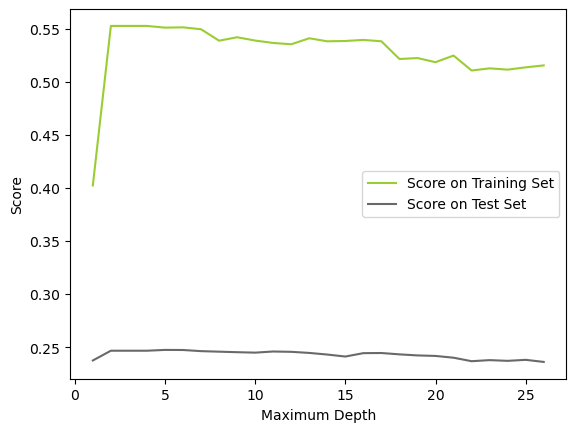

In [41]:
plt.plot(list(range(1,len(X_rand.columns)+1)), train_scores, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,len(X_rand.columns)+1)), val_scores, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

In [7]:
model = GradientBoostingClassifier()
rfe = RFE(estimator = model, n_features_to_select = 8)
rfe.fit_transform(X_rand, y_train)

array([[-0.25035115, -0.16216216, -1.        , ..., -1.        ,
         0.06666667,  1.        ],
       [ 0.28119613, -0.83783784, -1.        , ..., -1.        ,
        -0.33333333,  0.67247588],
       [-0.53964931, -0.83783784, -1.        , ..., -1.        ,
        -0.46666667,  0.838589  ],
       ...,
       [-0.03557735, -0.72972973, -0.9047619 , ...,  0.87969735,
         0.06666667,  0.67247588],
       [ 0.61523575, -0.37837838, -1.        , ..., -1.        ,
         0.06666667,  0.838589  ],
       [ 0.51636738, -0.48648649, -0.71428571, ...,  0.93060676,
         0.06666667,  0.838589  ]])

In [23]:
feature_importances = permutation_importance(model.fit(X_rand, y_train), X_rand, y_train)

sorted_indices = np.argsort(feature_importances)[::-1] # descending order
feature_ranking = [(i, score) for i, score in enumerate(feature_importances[sorted_indices])]

TypeError: unhashable type: 'numpy.ndarray'

In [8]:
selected_features = pd.DataFrame(rfe.support_, index = X_rand.columns, columns=['RFE_Keep'])
names = np.array(selected_features[selected_features.values == True].index)
names
selected_features.sort_index()

,RFE_Keep
age_mean,False
age_mean_log,True
age_mean_win_log,False
average_pulse_bpm,False
emergency_visits_in_previous_year,False
emergency_visits_in_previous_year_log,False
emergency_visits_in_previous_year_win_log,False
inpatient_visits_in_previous_year,True
inpatient_visits_in_previous_year_log,True
inpatient_visits_in_previous_year_win_log,True


In [9]:
# pd.DataFrame({'coef': coef.reshape(-1)}, index=names).sort_index()

In [10]:
metric_to_keep = ['age_mean',
       'non_lab_procedures.1',
       'inpatient_visits_in_previous_year.1',
       'emergency_visits_in_previous_year.1', 'number_diagnoses',
       'number_of_medications_log', 'length_of_stay_in_hospital_log', 'number_lab_tests']

len(metric_to_keep)

8

In [11]:
lasso_cv = ElasticNetCV(cv=10)
lasso_cv.fit(X_rand, y_train)
feature_names = X_rand.columns
coefficients = lasso_cv.coef_

lasso_metric = pd.DataFrame(data=coefficients, index=feature_names, columns=['Coefficient'])
lasso_metric = lasso_metric[lasso_metric['Coefficient'].abs() > 0.001]
lasso_metric.sort_index()

,Coefficient
age_mean,0.157434
age_mean_log,-0.091981
age_mean_win_log,-0.038852
average_pulse_bpm,-0.006108
emergency_visits_in_previous_year_log,0.018533
emergency_visits_in_previous_year_win_log,0.003443
inpatient_visits_in_previous_year,0.435709
inpatient_visits_in_previous_year_win_log,0.040341
length_of_stay_in_hospital,-0.021123
length_of_stay_in_hospital_log,0.015394


In [12]:
# selected_features["lasso_keep"] = [np.abs(coefficients) > 0.001]
# selected_features

lasso_keep = pd.DataFrame(data=coefficients, index=feature_names, columns=['lasso_keep'])
selected_features = selected_features.join(lasso_keep)

In [13]:
selected_features['lasso_keep'] = selected_features['lasso_keep'] > 0.001

In [14]:
selected_features

,RFE_Keep,lasso_keep
length_of_stay_in_hospital_win_log,True,True
number_diagnoses_win_log,False,False
average_pulse_bpm,False,False
non_lab_procedures,False,False
length_of_stay_in_hospital,False,False
number_of_medications_log,False,True
number_of_medications,True,False
age_mean_win_log,False,False
number_of_medications_win_log,False,False
inpatient_visits_in_previous_year,True,True


In [15]:
lasso_to_keep = ['age_mean', 'average_pulse_bpm',
       'emergency_visits_in_previous_year.1',
       'inpatient_visits_in_previous_year.1',
       'length_of_stay_in_hospital_log', 'non_lab_procedures',
       'number_diagnoses_log', 'number_lab_tests.1',
       'number_of_medications_log', 'outpatient_visits_in_previous_year']

In [16]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=69, max_depth=8, min_samples_split=16, max_samples=0.6, max_features=None)

In [17]:
importances = rf_classifier.fit(X_rand, y_train).feature_importances_

In [18]:
all_importance = pd.DataFrame(importances, columns=['importance'], index = X_rand.columns).sort_values(by='importance', ascending=False)
all_importance['agg_sum'] = all_importance['importance'].cumsum()
all_importance['keep_rfc'] = all_importance['agg_sum'] <= 0.8
all_importance


,importance,agg_sum,keep_rfc
inpatient_visits_in_previous_year,0.159669,0.159669,True
inpatient_visits_in_previous_year_log,0.157692,0.317361,True
inpatient_visits_in_previous_year_win_log,0.149077,0.466439,True
number_lab_tests,0.094993,0.561432,True
average_pulse_bpm,0.077249,0.638681,True
length_of_stay_in_hospital_log,0.030958,0.669639,True
number_of_medications_log,0.028789,0.698428,True
number_of_medications,0.028217,0.726645,True
number_of_medications_win_log,0.027019,0.753664,True
length_of_stay_in_hospital_win_log,0.026190,0.779854,True


In [19]:
selected_features = selected_features.join(all_importance['keep_rfc'])

In [20]:
selected_features['keep'] = selected_features.apply(lambda votes: (votes == True).sum() > 1, axis=1)

In [21]:
selected_features

,RFE_Keep,lasso_keep,keep_rfc,keep
length_of_stay_in_hospital_win_log,True,True,True,True
number_diagnoses_win_log,False,False,False,False
average_pulse_bpm,False,False,True,False
non_lab_procedures,False,False,False,False
length_of_stay_in_hospital,False,False,False,False
number_of_medications_log,False,True,True,True
number_of_medications,True,False,True,True
age_mean_win_log,False,False,False,False
number_of_medications_win_log,False,False,True,False
inpatient_visits_in_previous_year,True,True,True,True


In [51]:
new_metric_to_keep = selected_features['keep'][selected_features['keep'] == True].index.tolist()

In [64]:
rf_keep = ['average_pulse_bpm.1', 'number_lab_tests', 'number_of_medications', 'age_mean',
       'length_of_stay_in_hospital', 'inpatient_visits_in_previous_year.1', 'non_lab_procedures']

### former categorical variables

In [24]:
cat_features = [x for x in X_train.columns if x not in metric_features]
cat_features

['race_0',
 'race_1',
 'race_2',
 'race_3',
 'gender',
 'age_0',
 'age_1',
 'age_2',
 'age_3',
 'age_4',
 'age_5',
 'age_6',
 'age_7',
 'age_8',
 'payer_code',
 'admission_type_0',
 'admission_type_1',
 'admission_type_2',
 'admission_type_3',
 'admission_type_4',
 'discharge_disposition',
 'admission_source',
 'glucose_test_result_0',
 'glucose_test_result_1',
 'glucose_test_result_2',
 'a1c_test_result_0',
 'a1c_test_result_1',
 'a1c_test_result_2',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'is_outpatient_visited',
 'is_emergency_visited',
 'is_inpatient_visited',
 'is_pulse_normal',
 'primary_diagnosis_cat',
 'secondary_diagnosis_cat',
 'additional_diagnosis_cat',
 'discharge_disposition_cat_0',
 'discharge_disposition_cat_1',
 'discharge_disposition_cat_2',
 'discharge_disposition_cat_3',
 'admission_source_cat_0',
 'admission_source_cat_1',
 'admission_source_cat_2',
 'admission_source_cat_3',
 'admission_source_cat_4',
 'med_acarbose',
 'med_glyburid

In [25]:
X_rand_c = X_train[cat_features].sample(frac=1, axis=1)
X_val_cat = X_val[cat_features].reindex(columns=X_rand.columns)

In [28]:
def TestIndependence(X,y,var,alpha=0.05):  
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    return p<alpha

In [27]:
keep_chi2 = []

for var in X_rand_c[cat_features]:
    keep_var = TestIndependence(X_train[var], y_train['readmitted_binary'], var)
    keep_chi2.append(keep_var)

In [31]:
selected_cat_features = pd.DataFrame(data=keep_chi2, columns=['keep_chi2'], index=X_rand_c.columns)
selected_cat_features

,keep_chi2
secondary_diagnosis_cat,True
med_metformin,True
payer_code,True
age_4,True
admission_source_cat_4,True
...,...
admission_type_1,False
prescribed_diabetes_meds,False
race_0,False
admission_source_cat_2,True


In [32]:
# chi2_selector = SelectKBest(chi2, k='all')
# X_chi2 = chi2_selector.fit_transform(X_balanced[cat_features], y_balanced)

mutual_info_selector = SelectKBest(mutual_info_classif, k='all')
X_mutual_info = mutual_info_selector.fit_transform(X_rand_c.sample(frac=1, axis=1)[cat_features], y_train)

KeyboardInterrupt: 

In [33]:
param_grid = {'k': [10, 20, 30, 40, 50, 'all']}  # Adjust the range as needed

# Create the mutual info selector
mutual_info_selector = SelectKBest(mutual_info_classif)
grid_search = GridSearchCV(mutual_info_selector, param_grid, scoring='f1', cv=5)

# Fit the grid search on the training data
grid_search.fit(X_rand_c, y_train)

# Get the best value of k from the grid search
best_k = grid_search.best_params_['k']

# Refit the selector with the best k value on the full training set
mutual_info_selector = SelectKBest(mutual_info_classif, k=best_k)
X_mutual_info = mutual_info_selector.fit_transform(X_rand_c, y_train)

In [34]:
best_k

10

In [37]:
keep_mutual = mutual_info_selector.get_support()

In [38]:
selected_cat_features['keep_mutual'] = keep_mutual.reshape((-1, 1))
selected_cat_features

,keep_chi2,keep_mutual
secondary_diagnosis_cat,True,False
med_metformin,True,False
payer_code,True,False
age_4,True,False
admission_source_cat_4,True,False
...,...,...
admission_type_1,False,False
prescribed_diabetes_meds,False,False
race_0,False,False
admission_source_cat_2,True,False


In [39]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=69, max_features='sqrt', max_samples=0.6)
cat_importance = rf_classifier.fit(X_rand_c, y_train).feature_importances_
all_importance = pd.DataFrame(cat_importance, columns=['importance'], index = X_rand_c.columns).sort_values(by='importance', ascending=False)

all_importance['agg_sum'] = all_importance['importance'].cumsum()
all_importance['keep_rfc'] = all_importance['agg_sum'] <= 0.8
all_importance

,importance,agg_sum,keep_rfc
discharge_disposition,0.097903,0.097903,True
primary_diagnosis_cat,0.089017,0.186920,True
additional_diagnosis_cat,0.086085,0.273005,True
secondary_diagnosis_cat,0.086039,0.359044,True
payer_code,0.085291,0.444336,True
...,...,...,...
med_acetohexamide,0.000014,0.999984,False
med_glimepiride-pioglitazone,0.000007,0.999991,False
med_metformin-rosiglitazone,0.000003,0.999994,False
med_troglitazone,0.000003,0.999997,False


In [42]:
selected_cat_features = selected_cat_features.join(all_importance['keep_rfc'])

In [43]:
selected_cat_features['keep'] = selected_cat_features.apply(lambda votes: (votes == True).sum() > 1, axis=1)
selected_cat_features

,keep_chi2,keep_mutual,keep_rfc,keep
secondary_diagnosis_cat,True,False,True,True
med_metformin,True,False,True,True
payer_code,True,False,True,True
age_4,True,False,False,False
admission_source_cat_4,True,False,False,False
...,...,...,...,...
admission_type_1,False,False,False,False
prescribed_diabetes_meds,False,False,False,False
race_0,False,False,True,False
admission_source_cat_2,True,False,False,False


In [48]:
new_cat_to_keep = selected_cat_features[selected_cat_features['keep'] == True].index.tolist()

In [89]:
all_importance.index

Index(['discharge_disposition', 'additional_diagnosis_cat',
       'primary_diagnosis_cat', 'secondary_diagnosis_cat', 'payer_code',
       'admission_source', 'is_inpatient_visited', 'is_pulse_normal', 'gender',
       'is_emergency_visited', 'change_in_meds_during_hospitalization',
       'med_insulin', 'is_outpatient_visited', 'a1c_test_result_2',
       'a1c_test_result_0', 'med_metformin', 'age_2', 'admission_type_4',
       'age_4', 'age_8', 'discharge_disposition_cat_0', 'age_0',
       'admission_type_2', 'age_6', 'race_0'],
      dtype='object')

now decide which are the best from the selection criteria :)

| Feature                            | RFE_LR  | Lasso   | RFC     | Final_Decision |
|:-----------------------------------|:--------|:--------|:--------|:---------------|
| age_mean                           | keep    | keep | keep | keep        |
| outpatient                         | discard    | keep | discard | discard        |
| outpatient_log                     | discard    | keep | discard | discard        |
| outpatient_win                     | discard    | keep | discard | discard        |
| emergency                          | discard    | keep    | discard    | discard           |
| emergency_log                      | discard    | keep    | discard    | discard           |
| emergency_win                      | keep    | keep    | discard    | keep           |
| inpatient                          | keep    | keep    | keep    | keep           |
| inpatient_log                      | keep    | discard    | keep    | keep           |
| inpatient_win                      | keep    | keep    | keep    | keep           |
| average_pulse_bpm                  | discard    | keep | keep | keep        |
| average_pulse_bpm_win              | discard    | discard | keep | discard        |
| length_of_stay                    | discard    | discard    | keep    | discard           |
| length_of_stay_log                | keep    | keep    | keep    | keep           |
| length_of_stay_win                | discard    | discard    | keep    | keep           |
| number_lab_tests                   | keep    | discard | keep | keep        |
| number_lab_tests_win                   | keep    | keep | keep | keep        |
| non_lab_procedures                 | discard    | keep    | discard | discard           |
| non_lab_procedures_log                 | discard    | keep    | discard | discard           |
| non_lab_procedures_win                 | keep    | keep    | discard | keep           |
| number_of_medications              | discard    | discard    | keep    | discard           |
| number_of_medications_log              | keep    | keep    | keep    | keep           |
| number_of_medications_win              | keep    | keep    | keep    | keep           |
| number_diagnoses                   | keep    | keep    | discard    | keep           |
| number_diagnoses_log                   | keep    | keep    | discard    | keep           |
| number_diagnoses_win                   | keep    | discard    | discard    | discard           |

| Feature                                | chi2   | mutual | RFC   | Final_Decision |
|:---------------------------------------|:-------|:-------|:-----|:---------------|
| race_0                                 | keep   | keep   | keep | keep           |
| race_1                                 | discard| discard| discard | discard      |
| race_2                                 | keep   | discard| discard | discard      |
| race_3                                 | keep   | keep   | discard | keep      |
| gender                                 | keep   | discard| keep | keep       |
| age_0                                  | keep   | discard| keep | keep       |
| age_1                                  | keep   | discard| discard | discard      |
| age_2                                  | keep   | discard| keep | keep          |
| age_3                                  | keep   | discard| discard | discard      |
| age_4                                  | keep   | discard| keep | keep          |
| age_5                                  | keep   | keep   | discard | keep      |
| age_6                                  | keep   | keep   | keep | keep           |
| age_7                                  | keep   | discard| discard | discard      |
| age_8                                  | keep   | discard| keep | keep          |
| admission_type_0                      | keep   | discard| discard | discard      |
| admission_type_1                      | keep   | discard| discard | discard      |
| admission_type_2                      | keep   | discard| discard | discard      |
| admission_type_3                      | keep   | discard| discard | discard      |
| admission_type_4                      | keep   | discard| keep | keep          |
| discharge_disposition                 | keep   | discard| keep | keep          |
| payer_code                             | discard| discard| keep | discard       |
| admission_source                       | discard| discard| keep | discard       |
| glucose_test_result_0                 | keep   | discard| discard | discard      |
| glucose_test_result_1                 | keep   | discard| discard | discard      |
| glucose_test_result_2                 | keep   | discard| discard | discard      |
| a1c_test_result_0                     | keep   | discard| discard | discard      |
| a1c_test_result_1                     | keep   | discard| discard | discard      |
| a1c_test_result_2                     | keep   | discard| keep | keep          |
| change_in_meds_during_hospitalization | keep   | discard| keep | keep       |
| prescribed_diabetes_meds              | keep   | discard| discard | discard      |
| is_outpatient_visited                 | keep   | keep   | keep | keep           |
| is_emergency_visited                   | keep  | discard| keep | keep       |
| is_inpatient_visited                   | keep  | keep   | keep | keep           |
| is_pulse_normal                       | discard| discard| discard | discard      |
| primary_diagnosis_cat                  | discard| discard| keep | discard       |
| secondary_diagnosis_cat                | discard| discard| keep | discard       |
| additional_diagnosis_cat               | discard| discard| keep | discard       |
| discharge_disposition_cat_0           | keep  | discard| keep | keep       |
| discharge_disposition_cat_1           | keep  | discard| discard | discard      |
| discharge_disposition_cat_2           | keep  | discard| discard | discard      |
| discharge_disposition_cat_3           | keep  | discard| discard | discard      |
| admission_source_cat_0                | keep  | discard| keep | keep       |
| admission_source_cat_1                | keep  | keep   | discard | keep      |
| admission_source_cat_2                | keep  | discard| discard | discard      |
| admission_source_cat_3                | keep  | discard| keep | keep       |
| admission_source_cat_4                | keep  | discard| discard | discard      |
| med_metformin-pioglitazone            | discard| discard| discard | discard      |
| med_glimepiride                       | keep  | discard| keep | keep          |
| med_nateglinide                       | discard| discard| discard | discard      |
| med_rosiglitazone                     | discard| discard| discard | discard      |
| med_tolbutamide                       | discard| discard| discard | discard      |
| med_tolazamide                         | discard| discard| discard | discard      |
| med_glipizide-metformin               | discard| keep   | discard | discard      |
| med_glyburide                         | discard| keep   | discard | discard      |
| med_acarbose                           | discard| discard| discard | discard      |
| med_insulin                           | keep  | discard| keep | keep          |
| med_pioglitazone                       | discard| discard| discard | discard      |
| med_chlorpropamide                     | discard| discard| discard | discard      |
| med_acetohexamide                      | discard| discard| discard | discard      |
| med_metformin-rosiglitazone            | discard| discard| discard | discard      |
| med_metformin                         | keep  | discard| keep | keep          |
| med_troglitazone                       | discard| discard| discard | discard      |
| med_miglitol                           | discard| keep   | discard | discard      |
| med_glipizide                         | discard| discard| discard | discard      |
| med_glimepiride-pioglitazone          | discard| discard| discard | discard      |
| med_repaglinide                       | keep  | discard| keep | keep          |
| med_glyburide-metformin               | discard| discard| discard | discard      |


In [95]:
metric_keep = ['age_mean',
       'non_lab_procedures.1',
       'inpatient_visits_in_previous_year.1',
       'average_pulse_bpm',
       'emergency_visits_in_previous_year.1',
       'number_diagnoses',
       'number_of_medications_log',
       'length_of_stay_in_hospital_log',
       'number_lab_tests.1',
    ]

removed duplicates according to ranking and to the coeficients, in order to avoid collinearity in the features.

In [96]:
cat_keep = [
    "race_0",
    "race_3",
    "gender",
    "age_0",
    "age_2",
    "age_4",
    "age_5",
    "age_6",
    "age_8",
    "admission_type_4",
    "discharge_disposition",
    "a1c_test_result_2",
    "change_in_meds_during_hospitalization",
    "is_outpatient_visited",
    "is_emergency_visited",
    "is_inpatient_visited",
    "discharge_disposition_cat_0",
    "admission_source_cat_0",
    "admission_source_cat_1",
    "admission_source_cat_3",
    "med_glimepiride",
    "med_insulin",
    "med_repaglinide",
    "med_metformin",
]

In [52]:
features_to_keep = new_metric_to_keep + new_cat_to_keep
features_to_keep

['length_of_stay_in_hospital_win_log',
 'number_of_medications_log',
 'number_of_medications',
 'inpatient_visits_in_previous_year',
 'number_lab_tests',
 'inpatient_visits_in_previous_year_win_log',
 'inpatient_visits_in_previous_year_log',
 'number_diagnoses',
 'length_of_stay_in_hospital_log',
 'secondary_diagnosis_cat',
 'med_metformin',
 'payer_code',
 'discharge_disposition',
 'change_in_meds_during_hospitalization',
 'discharge_disposition_cat_1',
 'discharge_disposition_cat_3',
 'gender',
 'is_pulse_normal',
 'admission_type_2',
 'admission_source',
 'a1c_test_result_2',
 'age_2',
 'a1c_test_result_0',
 'glucose_test_result_1',
 'age_0',
 'age_8',
 'primary_diagnosis_cat',
 'discharge_disposition_cat_0',
 'is_outpatient_visited',
 'admission_type_4',
 'is_inpatient_visited',
 'is_emergency_visited',
 'med_insulin']

In [53]:
X_train_final = X_train[features_to_keep]
X_val_final = X_val[features_to_keep]
test_final = test[features_to_keep]

In [55]:
X_train_final.shape

(101256, 33)

In [54]:
X_train_final.to_csv("../data/input/train_final.csv")
X_val_final.to_csv("../data/input/val_final.csv")
test_final.to_csv("../data/input/test_final.csv")